# Case 2 - Myocardial infarction complications

In [1]:
# Import packages

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
sns.set() # Set searborn as default

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn import decomposition
from collections import defaultdict

# Data loading and pre-processing

The myocardial infarction complications data set consists of 1700 samples and 124 attributes.

In [2]:
# Load .CSV data file
df = pd.read_csv('Myocardial infarction complications Database.csv', na_values='?')
df

ID   AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  IBS_NASL  \
0        1  77.0    1       2.0        1.0        1.0       2.0       NaN   
1        2  55.0    1       1.0        0.0        0.0       0.0       0.0   
2        3  52.0    1       0.0        0.0        0.0       2.0       NaN   
3        4  68.0    0       0.0        0.0        0.0       2.0       NaN   
4        5  60.0    1       0.0        0.0        0.0       2.0       NaN   
...    ...   ...  ...       ...        ...        ...       ...       ...   
1695  1696  77.0    0       0.0        4.0        2.0       1.0       NaN   
1696  1697  70.0    0       0.0        6.0        2.0       1.0       NaN   
1697  1698  55.0    1       3.0        6.0        2.0       2.0       NaN   
1698  1699  79.0    0       2.0        2.0        2.0       1.0       NaN   
1699  1700  63.0    1       2.0        NaN        NaN       NaN       NaN   

       GB  SIM_GIPERT  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  \
0     3.0         0.0  ...          0           0         0          0   
1     0.0         0.0  ...          0           0         0          0   
2     2.0         0.0  ...          0           0         0          0   
3     2.0         0.0  ...          0           0         0          0   
4     3.0         0.0  ...          0           0         0          0   
...   ...         ...  ...        ...         ...       ...        ...   
1695  2.0         0.0  ...          0           0         1          0   
1696  2.0         0.0  ...          0           0         0          0   
1697  0.0         0.0  ...          0           0         0          0   
1698  2.0         0.0  ...          0           0         0          1   
1699  2.0         0.0  ...          0           0         0          0   

      RAZRIV  DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0          0         0    0       0          0       0  
1          0         0    0       0          0       0  
2          0         0    0       0          0       0  
3          0         0    1       0          0       0  
4          0         0    0       0          0       0  
...      ...       ...  ...     ...        ...     ...  
1695       1         0    0       0          0       3  
1696       0         0    0       0          0       1  
1697       0         0    0       1          0       6  
1698       0         0    0       0          0       1  
1699       0         0    0       0          0       1  

[1700 rows x 124 columns]

In [3]:
# # Check number of missing values for each attribute
# df.isna().sum(axis=0).plot.bar()

The dataset contains very many null-values (only the input variables).

In [4]:
# Remove columns if they contain more than 30% missing values
nan_columns = df.isna().sum(axis=0) > len(df)*0.3
columns_removed = df.columns[nan_columns]

df = df.drop(columns_removed,axis=1)

# Remove rows if they cointain more than 25% missing values
rows_removed = []
for row in df.iterrows():
    if row[1].isna().sum() >= df.shape[1]*0.25:
        rows_removed.append(row)
        df.drop(row[0], inplace=True, axis=0)

In [5]:
# Neglect ID, because unimportant for the analysis
df = df.drop("ID",axis=1)
df

AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  SIM_GIPERT  \
0     77.0    1       2.0        1.0        1.0       2.0  3.0         0.0   
1     55.0    1       1.0        0.0        0.0       0.0  0.0         0.0   
2     52.0    1       0.0        0.0        0.0       2.0  2.0         0.0   
3     68.0    0       0.0        0.0        0.0       2.0  2.0         0.0   
4     60.0    1       0.0        0.0        0.0       2.0  3.0         0.0   
...    ...  ...       ...        ...        ...       ...  ...         ...   
1694  77.0    0       0.0        0.0        0.0       0.0  2.0         0.0   
1695  77.0    0       0.0        4.0        2.0       1.0  2.0         0.0   
1696  70.0    0       0.0        6.0        2.0       1.0  2.0         0.0   
1698  79.0    0       2.0        2.0        2.0       1.0  2.0         0.0   
1699  63.0    1       2.0        NaN        NaN       NaN  2.0         0.0   

      DLIT_AG  ZSN_A  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  RAZRIV  \
0         7.0    0.0  ...          0           0         0          0       0   
1         0.0    0.0  ...          0           0         0          0       0   
2         2.0    0.0  ...          0           0         0          0       0   
3         3.0    1.0  ...          0           0         0          0       0   
4         7.0    0.0  ...          0           0         0          0       0   
...       ...    ...  ...        ...         ...       ...        ...     ...   
1694      7.0    0.0  ...          0           0         0          0       1   
1695      7.0    0.0  ...          0           0         1          0       1   
1696      7.0    0.0  ...          0           0         0          0       0   
1698      7.0    NaN  ...          0           0         0          1       0   
1699      NaN    4.0  ...          0           0         0          0       0   

      DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0            0    0       0          0       0  
1            0    0       0          0       0  
2            0    0       0          0       0  
3            0    1       0          0       0  
4            0    0       0          0       0  
...        ...  ...     ...        ...     ...  
1694         0    0       0          0       3  
1695         0    0       0          0       3  
1696         0    0       0          0       1  
1698         0    0       0          0       1  
1699         0    0       0          0       1  

[1649 rows x 116 columns]

Removing variables that contains more 30% NaNs for all samples which means that 7 variables are removed.

## Input variables
Neglecting the first column "ID" because it cannot be related to the participant.

In [6]:
X = df.iloc[:,:112]
X

AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  SIM_GIPERT  \
0     77.0    1       2.0        1.0        1.0       2.0  3.0         0.0   
1     55.0    1       1.0        0.0        0.0       0.0  0.0         0.0   
2     52.0    1       0.0        0.0        0.0       2.0  2.0         0.0   
3     68.0    0       0.0        0.0        0.0       2.0  2.0         0.0   
4     60.0    1       0.0        0.0        0.0       2.0  3.0         0.0   
...    ...  ...       ...        ...        ...       ...  ...         ...   
1694  77.0    0       0.0        0.0        0.0       0.0  2.0         0.0   
1695  77.0    0       0.0        4.0        2.0       1.0  2.0         0.0   
1696  70.0    0       0.0        6.0        2.0       1.0  2.0         0.0   
1698  79.0    0       2.0        2.0        2.0       1.0  2.0         0.0   
1699  63.0    1       2.0        NaN        NaN       NaN  2.0         0.0   

      DLIT_AG  ZSN_A  ...  TIKL_S_n  TRENT_S_n  FIBR_PREDS  PREDS_TAH  \
0         7.0    0.0  ...       0.0        0.0           0          0   
1         0.0    0.0  ...       0.0        1.0           0          0   
2         2.0    0.0  ...       0.0        0.0           0          0   
3         3.0    1.0  ...       0.0        0.0           0          0   
4         7.0    0.0  ...       0.0        1.0           0          0   
...       ...    ...  ...       ...        ...         ...        ...   
1694      7.0    0.0  ...       0.0        0.0           0          0   
1695      7.0    0.0  ...       0.0        0.0           0          0   
1696      7.0    0.0  ...       0.0        0.0           0          0   
1698      7.0    NaN  ...       0.0        0.0           0          0   
1699      NaN    4.0  ...       0.0        0.0           0          0   

      JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  RAZRIV  DRESSLER  
0             0           0         0          0       0         0  
1             0           0         0          0       0         0  
2             0           0         0          0       0         0  
3             0           0         0          0       0         0  
4             0           0         0          0       0         0  
...         ...         ...       ...        ...     ...       ...  
1694          0           0         0          0       1         0  
1695          0           0         1          0       1         0  
1696          0           0         0          0       0         0  
1698          0           0         0          1       0         0  
1699          0           0         0          0       0         0  

[1649 rows x 112 columns]

## Output variables
Most important output variable / target value (y) is Lethal outcome with column name "LET_IS"

In [7]:
Y = df.iloc[:,112:]
Y

ZSN  REC_IM  P_IM_STEN  LET_IS
0       0       0          0       0
1       0       0          0       0
2       0       0          0       0
3       1       0          0       0
4       0       0          0       0
...   ...     ...        ...     ...
1694    0       0          0       3
1695    0       0          0       3
1696    0       0          0       1
1698    0       0          0       1
1699    0       0          0       1

[1649 rows x 4 columns]

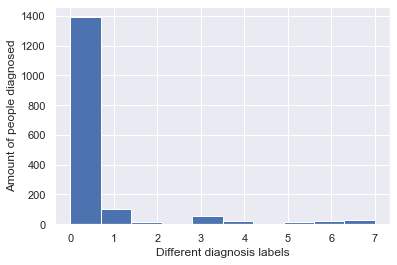

In [8]:
y = Y['LET_IS']

plt.hist(y)
plt.xlabel('Different diagnosis labels')
plt.ylabel('Amount of people diagnosed')
plt.show()

In [9]:
# Taken from https://github.com/auranic/ClinTrajan/blob/master/code/clintraj_qi.py for all columns

def detect_variable_type(df,Max_Number_Of_Ordinal_Values=10,verbose=True):
    # classification of variables into continuous, binary, ordinal
    binary = []
    continuous = []
    ordinal = []
    variable_types = []

    for col in df.columns: 
        vals = np.sort(df[col].unique())
        #print(col,vals)
        vals = [x for x in vals if str(x) != 'nan']
        tp = 'UNKNOWN'
        # NaNs must be 
        if len(vals)==2 or len(vals)==1:
            tp = 'BINARY'
            binary.append(col)
        if len(vals)>Max_Number_Of_Ordinal_Values:
            tp = 'CONTINUOUS'
            continuous.append(col)
        if len(vals)>2 and len(vals)<=Max_Number_Of_Ordinal_Values:
            tp = 'ORDINAL'
            ordinal.append(col)
        variable_types.append(tp)
        if len(vals)>Max_Number_Of_Ordinal_Values:
            if verbose:
                print(col,'\t','\t[',np.min(vals),'... ',len(vals),'values...',np.max(vals),']\t',tp)
        else:
            if verbose:
                print(col,'\t',vals,'\t',len(vals),'\t',tp)
    return variable_types, binary, continuous, ordinal

variable_types, binary, continuous, ordinal = detect_variable_type(X,10,verbose=False)

In [10]:
print(len(binary))
np.array(binary)

82


array(['SEX', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04',
       'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08',
       'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03',
       'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04',
       'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST',
       'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01',
       'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07',
       'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03',
       'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08',
       'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03',
       'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07',
       'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11',
       'n_p_ecg_p_12', 'fibr_ter_01', 'fibr_ter_02', 'fibr_ter_03',
       'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08',
       'GIPO_K', 'GIPER_NA', 'NI

In [11]:
print(len(continuous))
continuous

9


['AGE',
 'S_AD_ORIT',
 'D_AD_ORIT',
 'K_BLOOD',
 'NA_BLOOD',
 'ALT_BLOOD',
 'AST_BLOOD',
 'L_BLOOD',
 'ROE']

In [12]:
print(len(ordinal))
np.array(ordinal)

21


array(['INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG',
       'ZSN_A', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'TIME_B_S',
       'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NA_R_1_n', 'NA_R_2_n',
       'NA_R_3_n', 'NOT_NA_1_n', 'NOT_NA_2_n', 'NOT_NA_3_n'], dtype='<U10')

In [13]:
def quantify_nans(df):
    # quantifying the nans
    print('Total number of missing values {} ({}%)'.format(df.isnull().sum().sum(),100*df.isnull().sum().sum()/(df.shape[0])/(df.shape[1])))
    
    dfc = df.dropna()
    print('Number of complete rows: {} ({}%)'.format(dfc.shape[0],100*dfc.shape[0]/df.shape[0]))
    
quantify_nans(X)

Total number of missing values 6786 (3.674304773455774%)
Number of complete rows: 544 (32.98969072164948%)


### One-hot encoding of ordinal variables
All ordinal variables are applied a "dummy" or one-hot encoding scheme.

In [14]:
X_one_hot = pd.get_dummies(X, prefix=ordinal, columns=ordinal)
X_one_hot

AGE  SEX  SIM_GIPERT  nr_11  nr_01  nr_02  nr_03  nr_04  nr_07  nr_08  \
0     77.0    1         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     55.0    1         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     52.0    1         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     68.0    0         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     60.0    1         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...    ...  ...         ...    ...    ...    ...    ...    ...    ...    ...   
1694  77.0    0         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1695  77.0    0         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1696  70.0    0         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1698  79.0    0         0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
1699  63.0    1         0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   

      ...  NOT_NA_1_n_2.0  NOT_NA_1_n_3.0  NOT_NA_1_n_4.0  NOT_NA_2_n_0.0  \
0     ...               0               0               0               1   
1     ...               0               0               0               1   
2     ...               0               1               0               0   
3     ...               0               0               0               1   
4     ...               0               0               0               1   
...   ...             ...             ...             ...             ...   
1694  ...               0               0               0               0   
1695  ...               0               0               0               0   
1696  ...               0               0               0               0   
1698  ...               0               0               0               0   
1699  ...               0               0               0               0   

      NOT_NA_2_n_1.0  NOT_NA_2_n_2.0  NOT_NA_2_n_3.0  NOT_NA_3_n_0.0  \
0                  0               0               0               1   
1                  0               0               0               1   
2                  0               1               0               0   
3                  0               0               0               1   
4                  0               0               0               1   
...              ...             ...             ...             ...   
1694               1               0               0               1   
1695               0               0               0               0   
1696               0               0               0               0   
1698               0               0               0               0   
1699               0               0               0               0   

      NOT_NA_3_n_1.0  NOT_NA_3_n_2.0  
0                  0               0  
1                  0               0  
2                  0               1  
3                  0               0  
4                  0               0  
...              ...             ...  
1694               0               0  
1695               0               0  
1696               0               0  
1698               0               0  
1699               0               0  

[1649 rows x 192 columns]

### Imputation of missing values in X

The types of strategies / method for imputation can be found in more detail here: \
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html, \
https://scikit-learn.org/stable/modules/impute.html

In [15]:
def impute(df, method):
    """
    Impute missing values using a pre-defined method
    :param df - pandas dataframe
    :param method - strategy parameter of SimpleImputer() function
    """ 
    
    df_copy = df.copy()
     
    imputer = SimpleImputer(missing_values=np.nan, strategy=method)
    imputed = imputer.fit_transform(df_copy)

    df_new = pd.DataFrame(imputed, columns=df_copy.columns)
    
    return df_new

method = 'most_frequent'   # most_frequent strategy corresponds to "mode"
X_imputed = impute(X_one_hot, method)

In [16]:
imputer = SimpleImputer(missing_values=np.nan, strategy=method)

In [18]:
imputer.fit(X_one_hot)

SimpleImputer(strategy='most_frequent')

In [19]:
imputer.transform(X_one_hot)

array([[77.,  1.,  0., ...,  1.,  0.,  0.],
       [55.,  1.,  0., ...,  1.,  0.,  0.],
       [52.,  1.,  0., ...,  0.,  0.,  1.],
       ...,
       [70.,  0.,  0., ...,  0.,  0.,  0.],
       [79.,  0.,  0., ...,  0.,  0.,  0.],
       [63.,  1.,  0., ...,  0.,  0.,  0.]])

In [66]:
# Check for missing values
X_imputed.isnull().sum().sum()

0

# Hierarchical clustering of X

### Ward-linkage

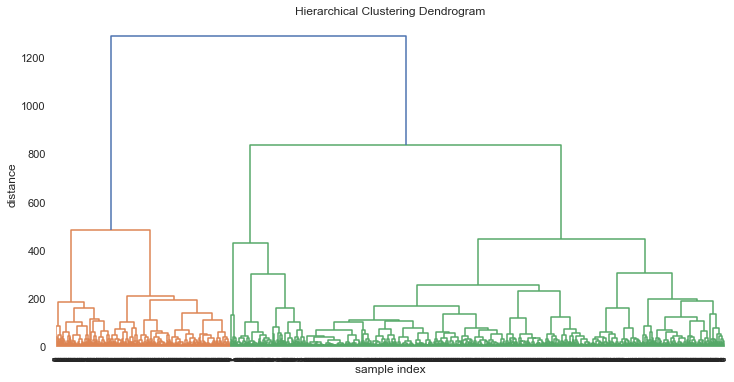

In [79]:
d_sample = 'euclidean'
d_group = 'ward'   # linkage
N_leafs = 1649 #Number of leaf nodes 

Z = linkage(X_imputed, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance
plt.figure(figsize=(12,6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

den = dendrogram(
    Z,
    labels=list(y),
    leaf_rotation=90.,
    leaf_font_size=8.,
#     color_threshold=0.8
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()

In [84]:
leaves = den['leaves']
unique_colors = np.unique(den["color_list"])
clust_dict = defaultdict(list)
for i in range(len(den["color_list"])):
    clust_dict[den["color_list"][i]].append(leaves[i])

In [92]:
from sklearn.metrics import accuracy_score

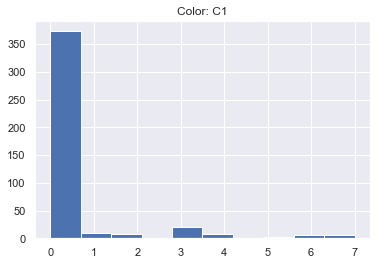

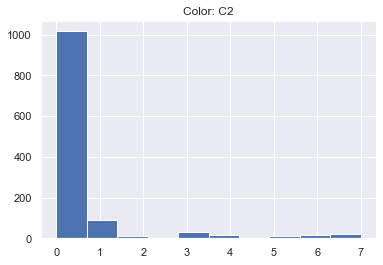

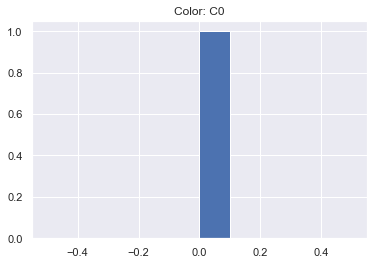

In [93]:
for col, labels in clust_dict.items():
    plt.hist(y.iloc[labels])
    plt.title(f"Color: {col}")
    plt.show()

# SVD

In [68]:
n_components = 3
model = decomposition.PCA(n_components = n_components)
X_transformed = model.fit_transform(X_imputed)
X_hat = X_transformed.dot(model.components_) + model.mean_

In [64]:
L = 0.5*np.linalg.norm(X_imputed-X_hat)**2
L

88206.08744446712